# Exploring possibilities for tiling topology
Started out looking at `topojson` as a pathway, but it turns out to not be entirely reliable for the usual floating point reasons, and the parameters for controlling its behaviour in relation to such things are hard to fully grok.

Instead, I've made a homegrown `Topology` class which assembles tiles, vertices, corners and edges from an input `TileUnit`. Implementation has also required development of a `Symmetries` class for determining the symmetries of polygons.

At present (10 Jan 2024) neither of these is built on 'lower level' classe such as `Tile` or `Symmetry` classes, although that might make sense in due course as the code has become fairly labyrinthine, but that refactoring should await greater clarity about the point of all this... so...

## What is the point of all this?
Well... modifying a tiling while preserving its essential features is difficult if tiles are simple features with no relations to one another. Topology may enable, for example, simplifying or complicating a specific edge in each tile of a tiling. 

Doing this requires knowing which edges are equivalent in the tiling such that changing edge (say) AB in one of the tiles, also requires that edge EF change in a matched way. Central to this are various approaches to labelling the elements of a tiling (principally its vertices and edges) in relation to its symmetries. Key references here are Chapter 5 of Grünbaum and Shephard, and related passages in Kaplan, although in both of these they are principally concerned with enumerating the isohedral tilings. 

For example, depending on which symmetries we consider a simple square tiling with modification of one edge of the original tiles can induce a variety of related tilings:

<img src="sketches/squares.png" style="width:50%">

(Imperfections in the drawing because those are simple features...). The square tiling case is complicated because it depends on knowing which of the many symmetries of the tile you want to use. With less symmetrical tiles, there is likely to be less choice - manipulating one edge will force changes in one or more corresponding edges, but with no choices available. For example, in the below example, moving a single vertex forces changes in the corresponding vertex which is differently position with respect to those other tiles.

<img src="sketches/hex-3.png" style="width:50%">

Either way a representation of tiling topology and tile symmetries is needed!

In [86]:
%matplotlib inline

import matplotlib.pyplot as pyplot
from collections import defaultdict
import copy

import numpy as np
from scipy import interpolate

import geopandas as gpd
import shapely.geometry as geom
import shapely.affinity as affine
import shapely.ops

from weavingspace import Topology
from weavingspace import TileShape
from weavingspace import TileUnit
from weavingspace import WeaveUnit
from weavingspace import Symmetries
from weavingspace import tiling_utils

In [87]:
square = tiling_utils.get_regular_polygon(200, 4)
L_shape = square.union(
  affine.translate(square, 200, 0)).union(
  affine.translate(square, 0, 200))
# L_shape = tiling_utils.get_clean_polygon(L_shape)

tile = TileUnit()
tile.base_shape = TileShape.HEXAGON
tile.tiles = gpd.GeoDataFrame(
  {"tile_id": list("abcd")},
  geometry = gpd.GeoSeries([affine.translate(L_shape, -100, 200), 
                            affine.translate(L_shape, 100, -200),
                            affine.translate(L_shape, -100, -400), 
                            affine.translate(L_shape, -300, 0)]))
tile.setup_regularised_prototile_from_tiles()
tile.prototile = gpd.GeoDataFrame(
  geometry = gpd.GeoSeries(
    geom.Polygon([(100, -450), (-300, -350), (-300, 350),
                  (-100, 450), (300, 350), (300, -350)])))
tile.vectors = tile.get_vectors()
# tile = tile.transform_rotate(90)

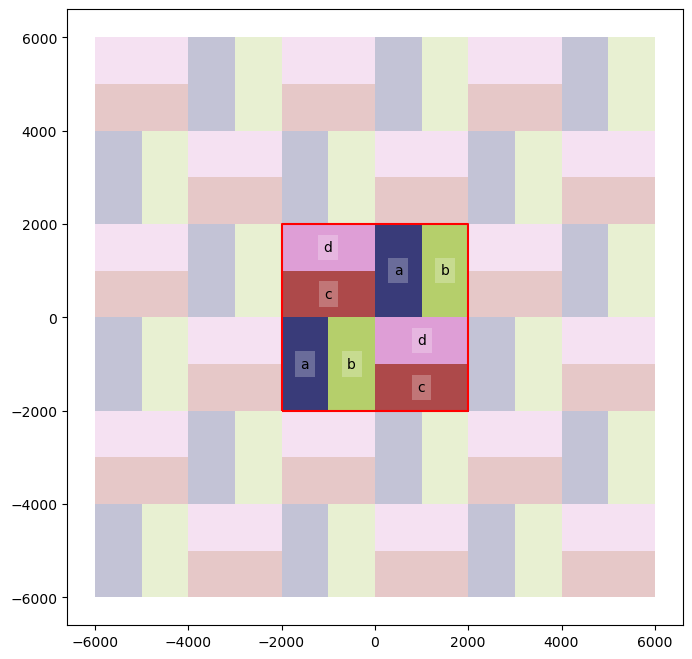

In [88]:
# tile = TileUnit(tiling_type = "archimedean", code = "3.3.4.3.4")
# tile = TileUnit(tiling_type = "hex-dissection", n = 7, offset = 1)
# tile = TileUnit(tiling_type = "hex-slice", n = 3, offset = 1)
# tile = TileUnit(tiling_type = "archimedean", code = "3.4.6.4")
# tile = TileUnit(tiling_type = "archimedean", code = "3.12.12")
# tile = TileUnit(tiling_type = "archimedean", code = "4.8.8")
# tile = TileUnit(tiling_type = "cairo", n = 3)
# tile = TileUnit(tiling_type = "hex-colouring", n = 3)
# .transform_skew(20).transform_scale(1.2)
# tile = WeaveUnit(weave_type = "plain", n = 2, strands = "a|d")
tile = WeaveUnit(weave_type = "basket", n = 2, strands = "ab|cd")
# tile = WeaveUnit(weave_type = "twill", n = 2, strands = "ab|cd")
ax = tile.plot(r = 1, show_reg_prototile = True, show_prototile = True, cmap = "tab20b", show_ids = True)

In [89]:
topo = Topology(tile)

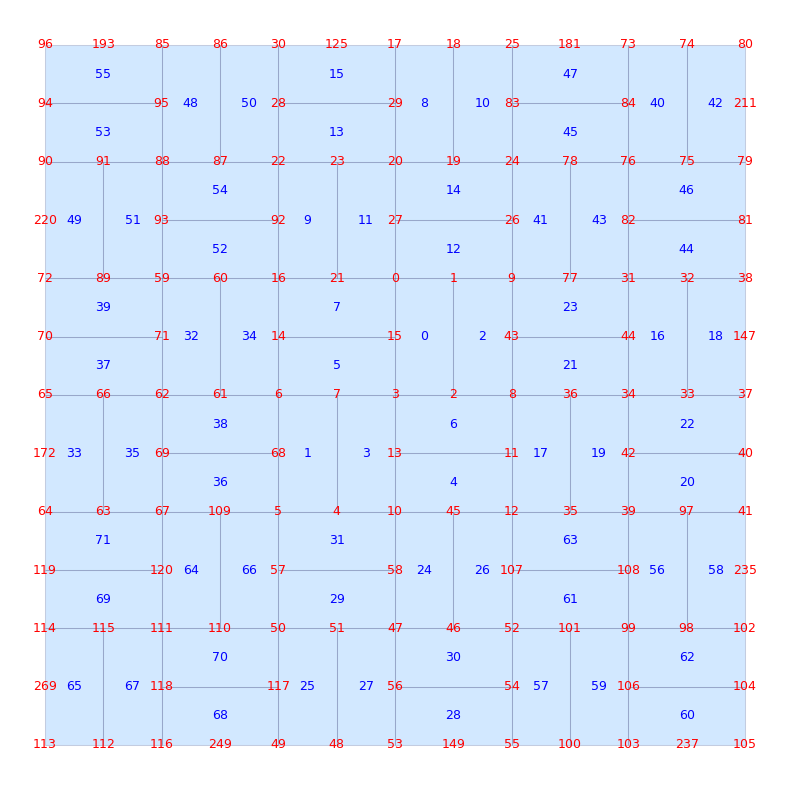

In [90]:
ax = topo.plot(
  show_original_tiles = True,
  show_tile_vertex_labels = False,
  show_tile_centres = True,
  show_vertex_labels = True,
  show_vertex_ids = True,
  show_edge_ids = True,
  show_edge_corners = False,
  show_edges = False,
  offset_edges = False,
  show_dual_tiles = False
)
# gpd.GeoSeries(symmetry_centres).plot(ax = ax)

In [91]:
def get_tile_equivalence_groups(topo, symmetries):
  n = topo.tile_unit.tiles.shape[0]
  n2 = topo.tile_unit.get_local_patch(r = 1, include_0 = True).shape[0]
  source_geoms = topo.tiles[:n]
  tgt_geoms = topo.tiles[:n2]
  equivalence_groups = defaultdict(set)
  for i in range(n):
    equivalence_groups[i].add(i)
  for s in symmetries:
    matched_geoms = [-1] * n
    for i, t in enumerate(source_geoms):
      sg = affine.affine_transform(t, s.transform)
      gmatches = [tiling_utils.geometry_matches(sg, tg) 
                  for tg in tgt_geoms]
      if any(gmatches):
        matched_geoms[i] = gmatches.index(True)
    if all([i >= 0 for i in matched_geoms]):
      for i, m in enumerate(matched_geoms):
        equivalence_groups[i].add(m % n)
        equivalence_groups[m % n].add(i)
  return equivalence_groups
  return set([tuple(sorted(v)) for v in equivalence_groups.values()])

In [92]:
ptile = topo.tile_unit.prototile.geometry[0]

base_symmetries = Symmetries(ptile).symmetries[1:] # ignore the identity
initial_groups = get_tile_equivalence_groups(topo, base_symmetries)
initial_groups


/Users/osullid3/miniconda3/envs/weaving/lib/python3.12/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


defaultdict(set,
            {0: {0, 3, 5, 6},
             1: {1, 2, 4, 7},
             2: {1, 2, 4, 7},
             3: {0, 3, 5, 6},
             4: {1, 2, 4, 7},
             5: {0, 3, 5, 6},
             6: {0, 3, 5, 6},
             7: {1, 2, 4, 7}})

In [93]:
# if len(initial_groups) > 0:
#   tiles_to_check = [_[0] for _ in initial_groups]
# else:
#   tiles_to_check = list(range(topo.tile_unit.tiles.shape[0]))

tiles_to_check = list(range(8))

vertex_centres = list(
  topo.get_geometries_induced_by_tiles(tiles_to_check, "vertices").values())

edge_centres = [
  ls.centroid for ls in 
  topo.get_geometries_induced_by_tiles(tiles_to_check, "edges").values()]

tile_centres = [topo.tile_centres[t] for t in tiles_to_check]

symmetry_centres = vertex_centres + edge_centres + tile_centres

In [94]:
x_symmetries = []
for s in base_symmetries:
  x_symmetries.extend([s] + [s.get_recentred(p) for p in symmetry_centres])


In [95]:

u_symmetries = []
while len(x_symmetries) > 0:
  s = x_symmetries[0]  
  u_symmetries.append(s)
  matches = [np.allclose(s.transform, sx.transform, rtol = 1e-6, atol = 1e-6) 
             for sx in x_symmetries]
  x_symmetries = [s for s, m in zip(x_symmetries, matches) if not m]


In [96]:

equivalence_groups = get_tile_equivalence_groups(topo, u_symmetries)
equivalence_groups

/Users/osullid3/miniconda3/envs/weaving/lib/python3.12/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


defaultdict(set,
            {0: {0, 2, 3, 4, 5, 6, 7},
             1: {1, 2, 3, 4, 5, 6, 7},
             2: {0, 1, 2, 4, 5, 6, 7},
             3: {0, 1, 3, 4, 5, 6, 7},
             4: {0, 1, 2, 3, 4, 6, 7},
             5: {0, 1, 2, 3, 5, 6, 7},
             6: {0, 1, 2, 3, 4, 5, 6},
             7: {0, 1, 2, 3, 4, 5, 7}})

<Axes: >

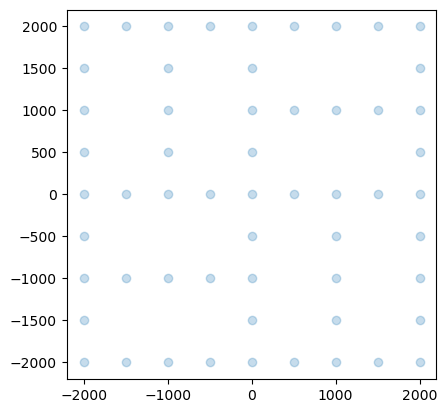

In [97]:
gpd.GeoSeries(symmetry_centres).plot(alpha = 0.25)